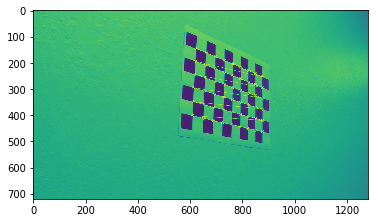

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from collections import deque
%matplotlib inline
#%matplotlib qt

# Read list of images
images = glob.glob('../camera_cal/calibration*.jpg')
objpoints = []
imgpoints = []

for fname in images:
    img = mpimg.imread(fname)
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # x, y coordinates

    # Convert image into grey scale
    grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(grey, (9,6), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(grey, (9,6), corners, ret)
        plt.imshow(img)

In [2]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, grey.shape[::-1], None, None)

# This function takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst



In [3]:
def show_2_images(img1, img1_title, img2, img2_title, cmap=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1, cmap)
    ax1.set_title(img1_title, fontsize=50)
    ax2.imshow(img2, cmap)
    ax2.set_title(img2_title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return ax1, ax2

(<matplotlib.axes._subplots.AxesSubplot at 0x2a74faf4ba8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a75129e080>)

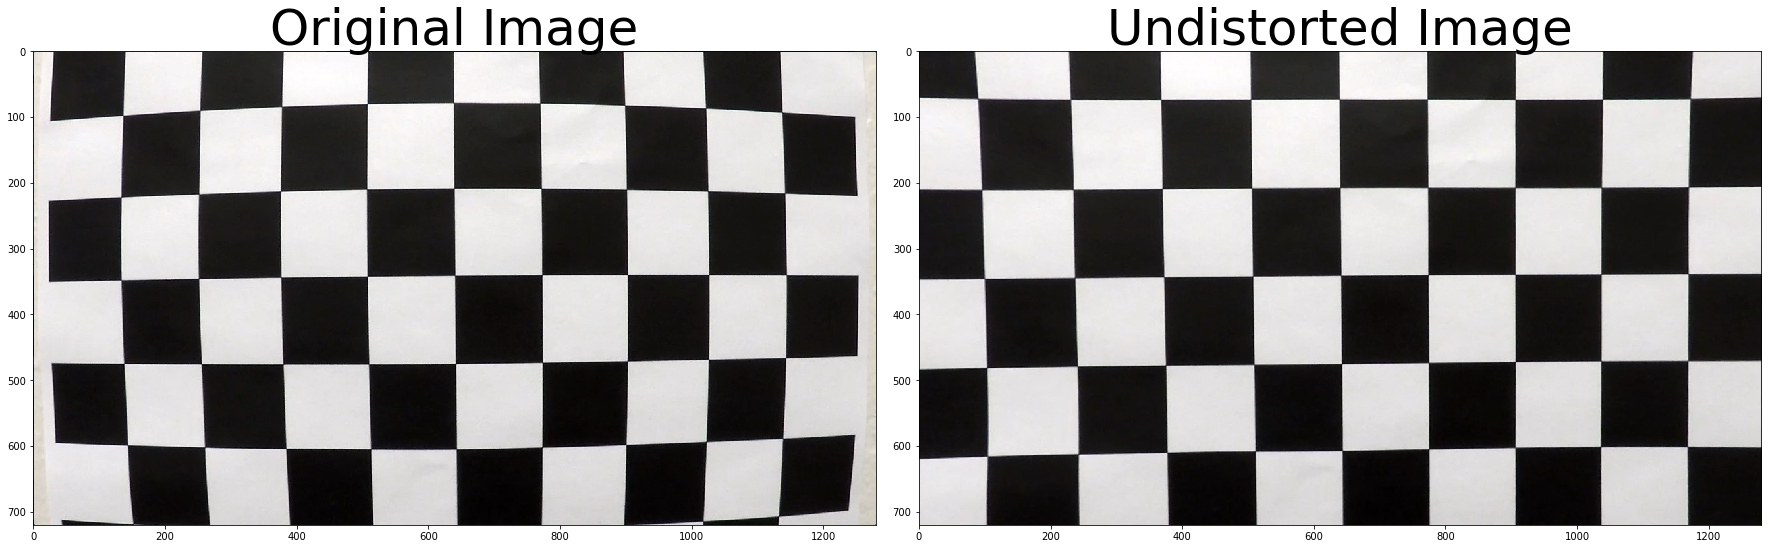

In [4]:
img = mpimg.imread(images[0])
undistorted = cal_undistort(img, mtx, dist)
show_2_images(img, 'Original Image', undistorted, 'Undistorted Image')

(<matplotlib.axes._subplots.AxesSubplot at 0x2a750f51518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a75137edd8>)

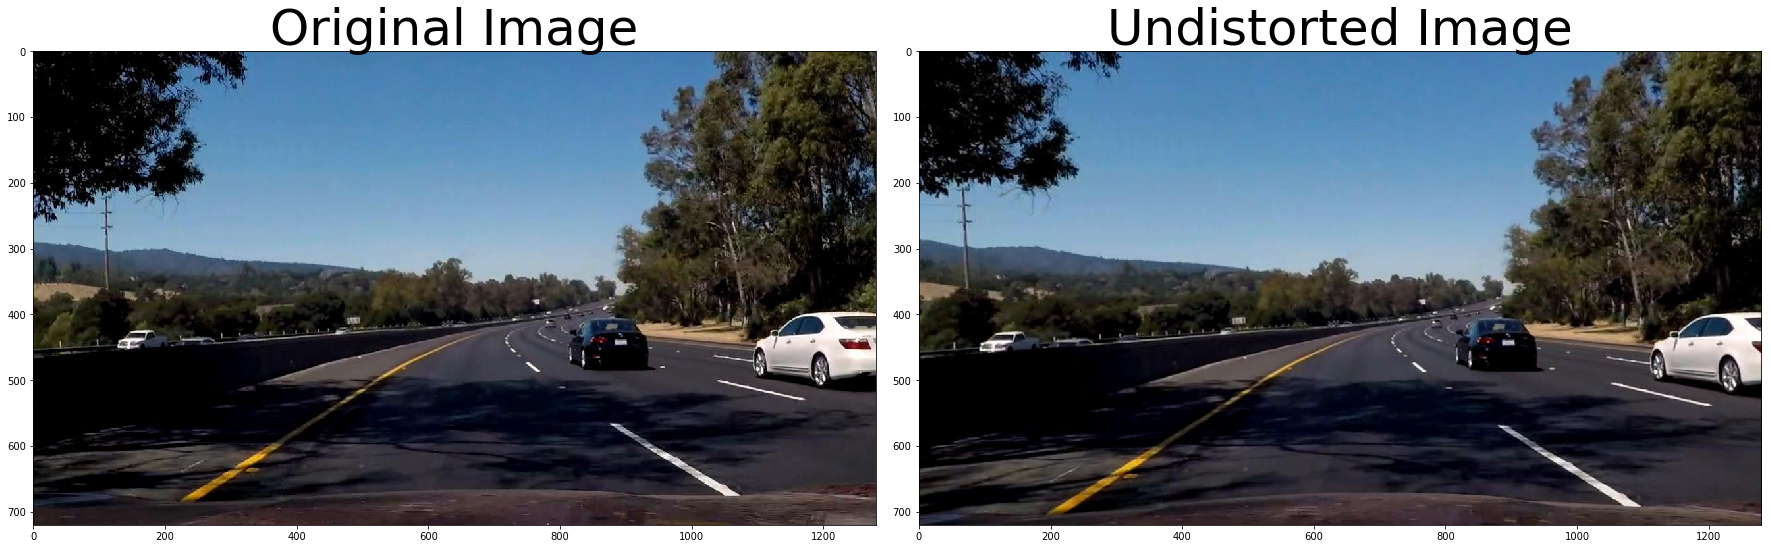

In [5]:
#Undistorting one of the test images
#img = mpimg.imread('../test_images/straight_lines1.jpg')
#img = mpimg.imread('../test_images/test3.jpg')
#img = mpimg.imread('../test_images/test1.jpg')
#img = mpimg.imread('../test_images/test2.jpg')
#img = mpimg.imread('../test_images/test4.jpg')
#img = mpimg.imread('../test_images/test5.jpg')
#img = mpimg.imread('../test_images/test5.jpg')
img = mpimg.imread('../test_images/test8.jpg')
undistorted = cal_undistort(img, mtx, dist)
show_2_images(img, 'Original Image', undistorted, 'Undistorted Image')


In [6]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

(<matplotlib.axes._subplots.AxesSubplot at 0x2a7511046a0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a75114dac8>)

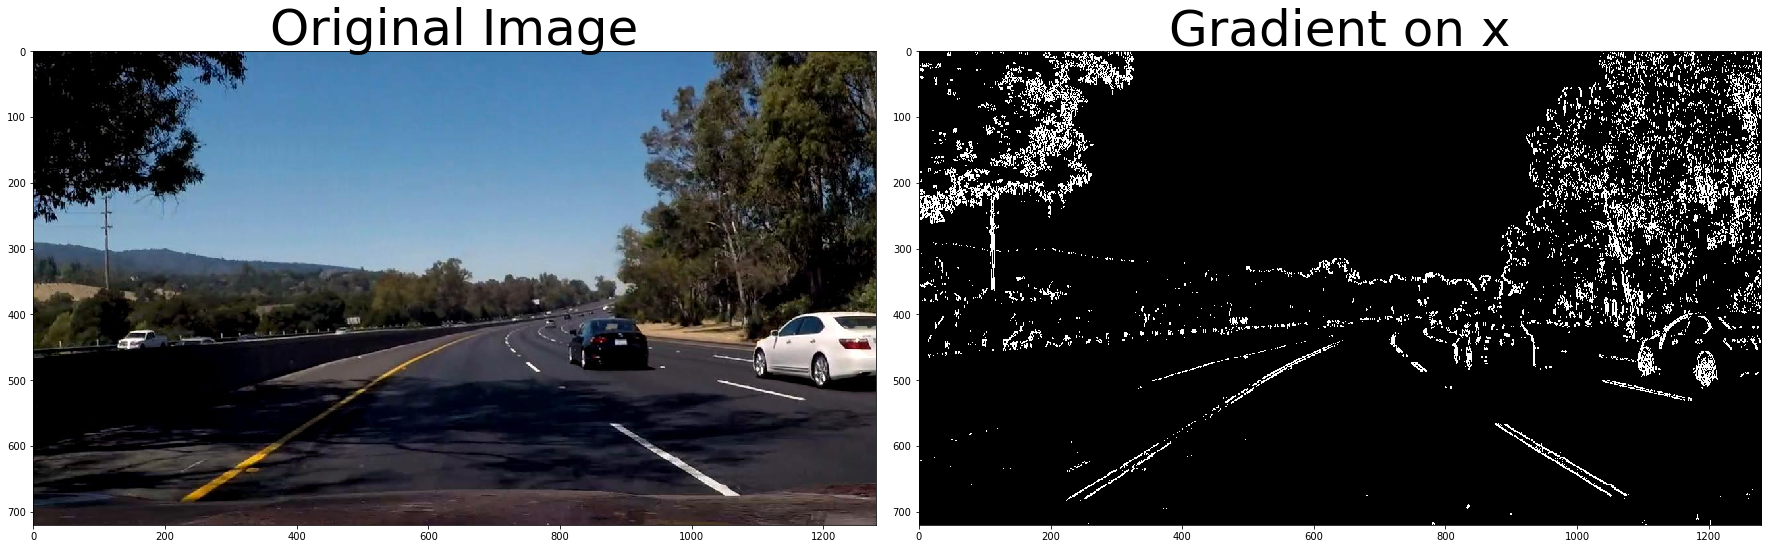

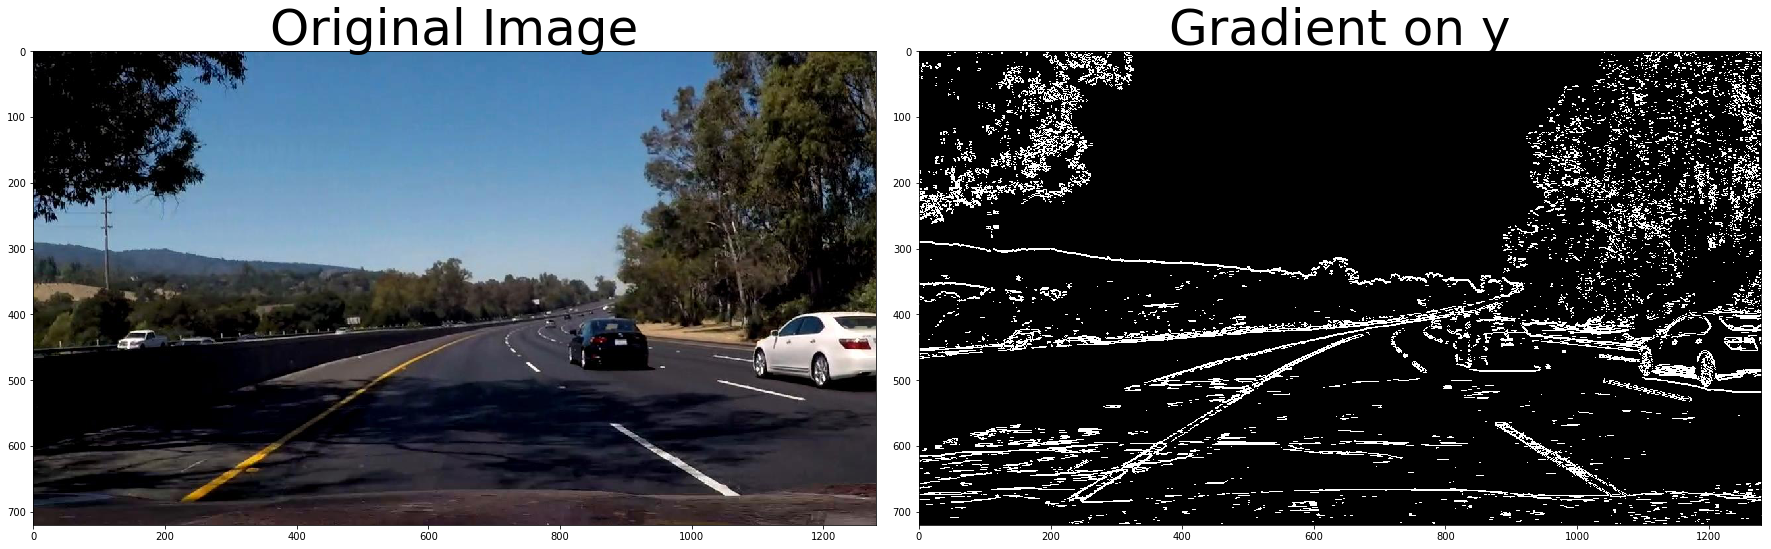

In [7]:
#Apply binary threshold by taking gradient on x
binary_x = abs_sobel_thresh(img, 'x', 3, (20, 150))
show_2_images(img, 'Original Image', binary_x, 'Gradient on x', 'gray')
#Apply binary threshold by taking gradient on y
binary_y = abs_sobel_thresh(img, 'y', 3, (20,150))
show_2_images(img, 'Original Image', binary_y, 'Gradient on y', 'gray')

In [8]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


(<matplotlib.axes._subplots.AxesSubplot at 0x2a7511b1ba8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a7510a3978>)

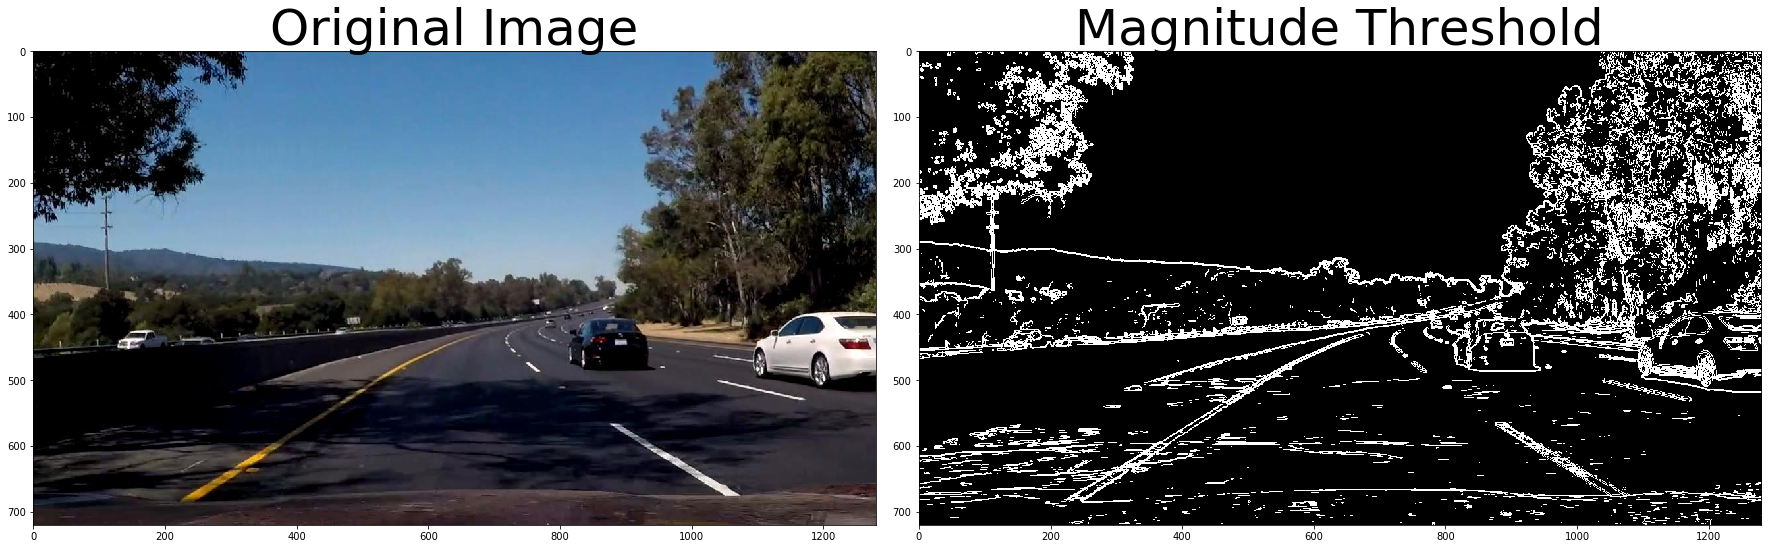

In [9]:
#Apply binary threshold by using magnitude threshold
mag_thresh_img= mag_thresh(img, 3, (20,150))
show_2_images(img, 'Original Image', mag_thresh_img, 'Magnitude Threshold', 'gray')

In [10]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

(<matplotlib.axes._subplots.AxesSubplot at 0x2a750ef6a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a751067ba8>)

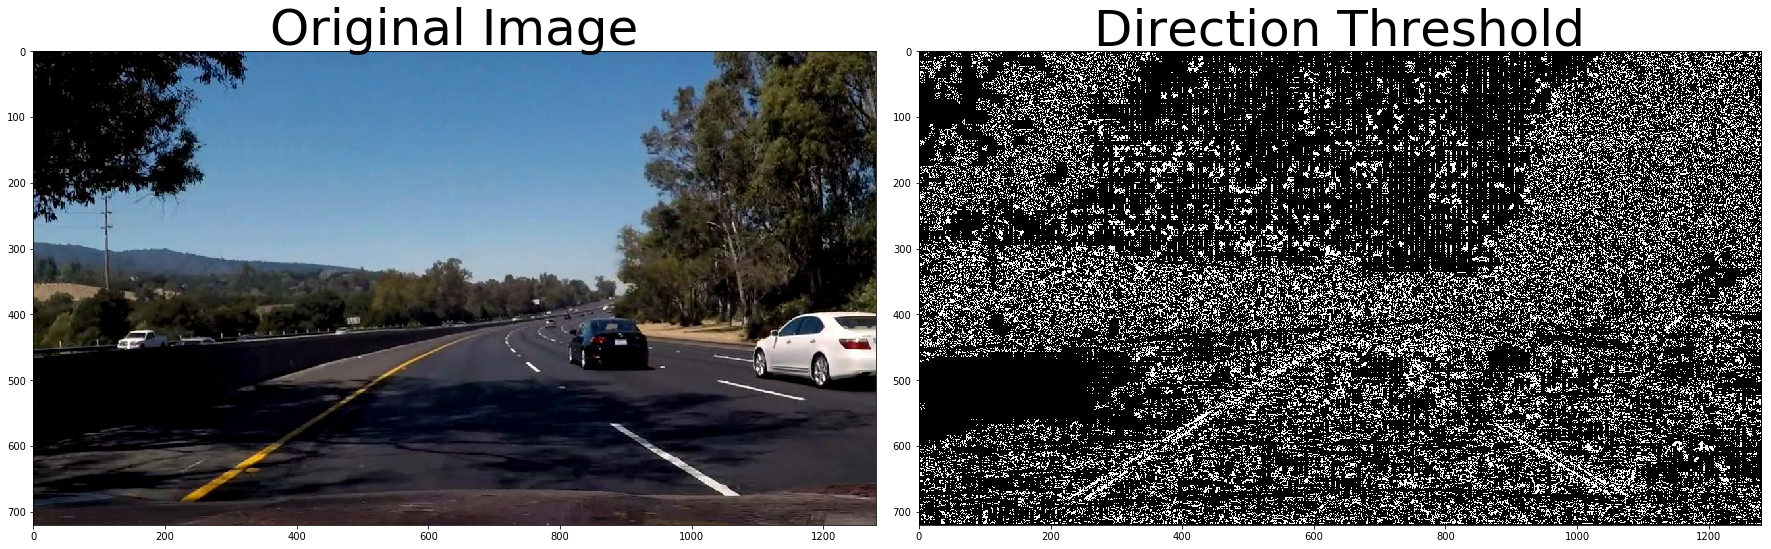

In [11]:
#using direction threshold
dir_thresh_img= dir_threshold(img, 3, (0.7, 1.2))
show_2_images(img, 'Original Image', dir_thresh_img, 'Direction Threshold', 'gray')

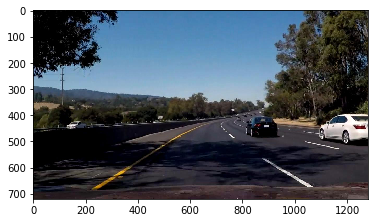

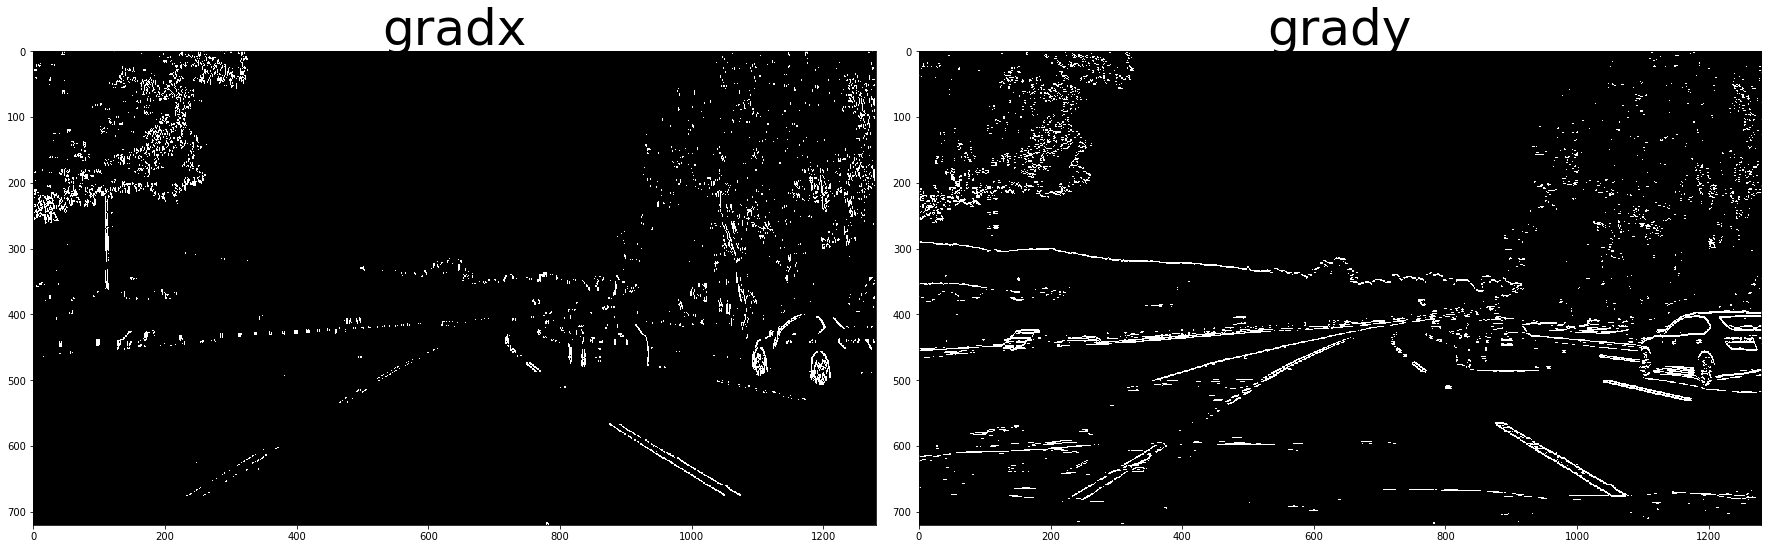

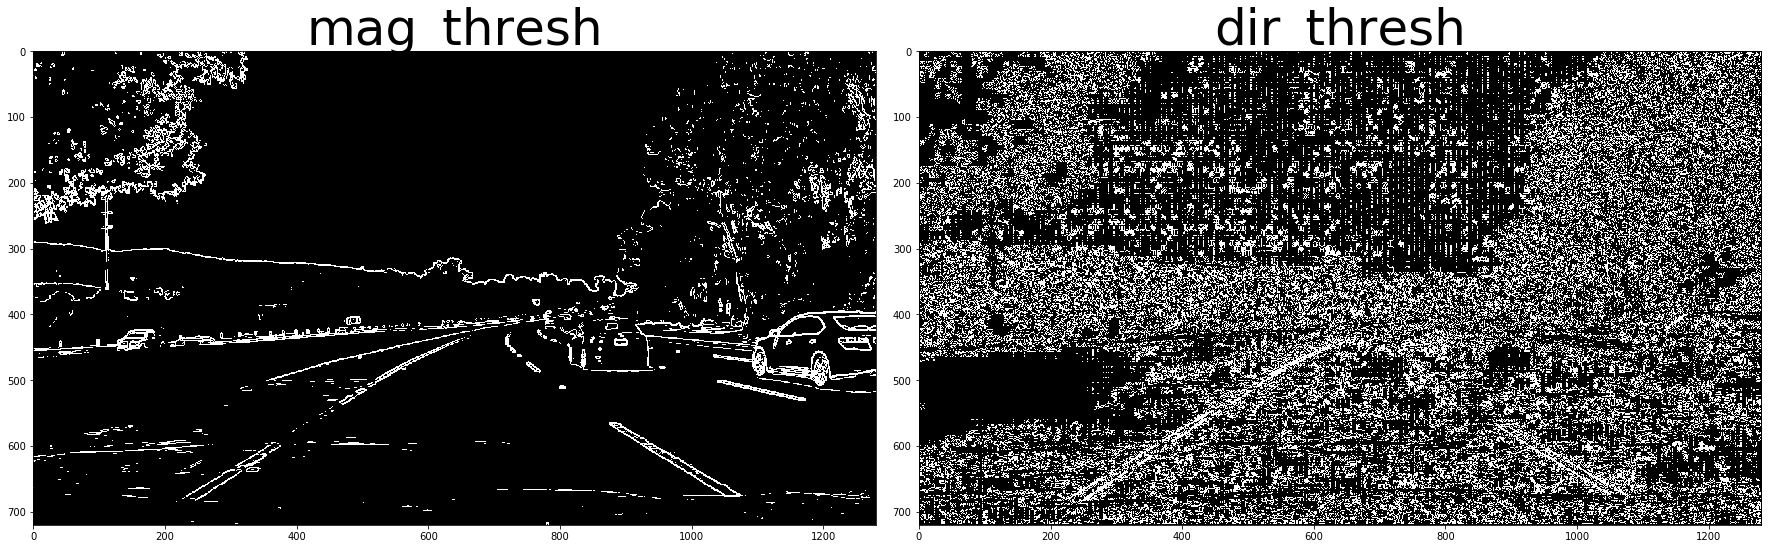

In [12]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements
plt.imshow(img)

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(40, 250))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(40, 250))
show_2_images(gradx, 'gradx', grady, 'grady', 'gray')

mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(40, 250))
dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
show_2_images(mag_binary, 'mag_thresh', dir_binary, 'dir_thresh', 'gray')

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#show_2_images(img, 'Original Image', combined, 'Combined Threshold', 'gray')


In [13]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255), l_thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    binary_s_channel = np.zeros_like(s_channel)
    binary_s_channel[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    binary_l_channel = np.zeros_like(l_channel)
    binary_l_channel[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    return binary_s_channel, binary_l_channel


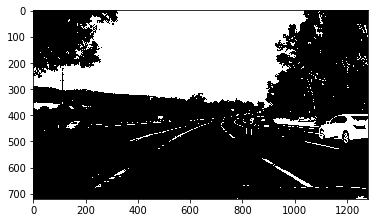

In [14]:
hls_img, l_channel = hls_select(img,(170,255), (100,255))
plt.imshow(hls_img, cmap='gray')
plt.imshow(l_channel, cmap='gray')


In [15]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100), l_thresh=(100,255)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    # Threshold s channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold l channel to remove shadows
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    # And l channel binary with s channel binary to remove shadows
    combined_binary[((s_binary == 1) &  (l_binary == 1)) | (sxbinary == 1)] = 1
    
    return sxbinary, s_binary, l_binary, combined_binary
    


(<matplotlib.axes._subplots.AxesSubplot at 0x2a75141f278>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a755b33cf8>)

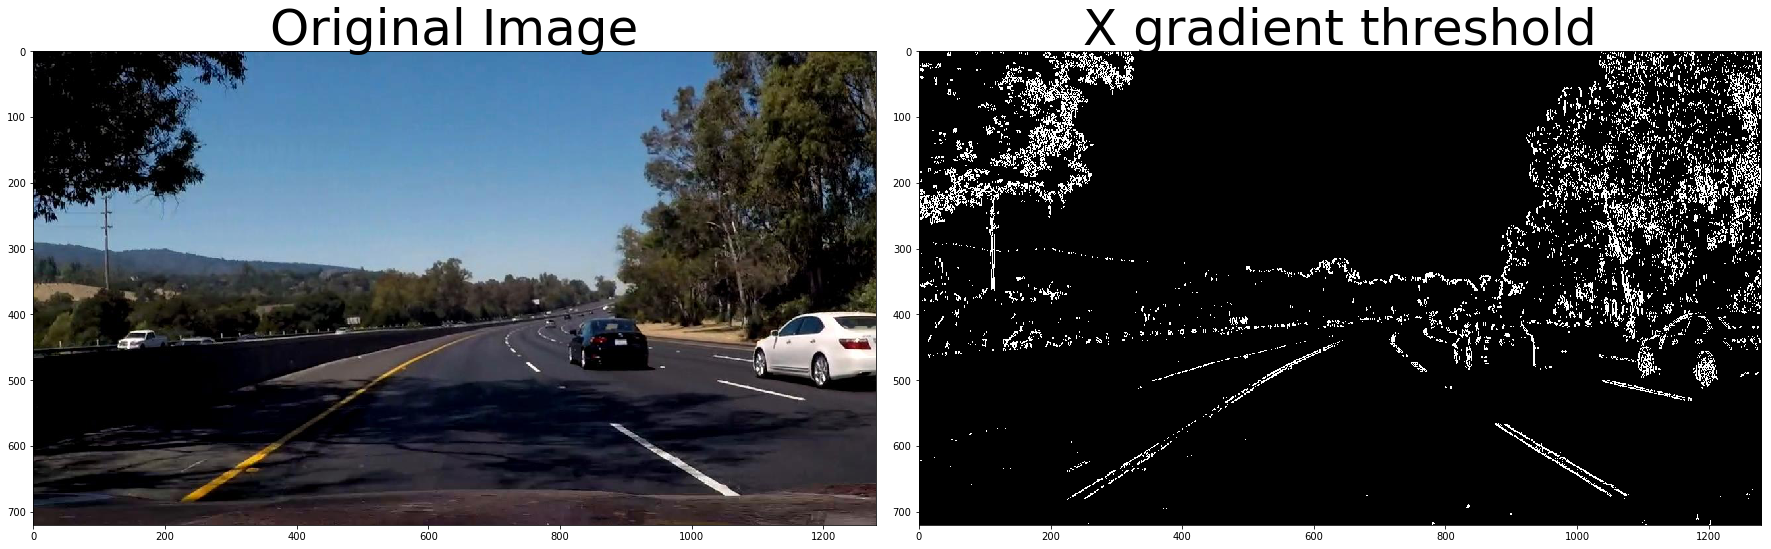

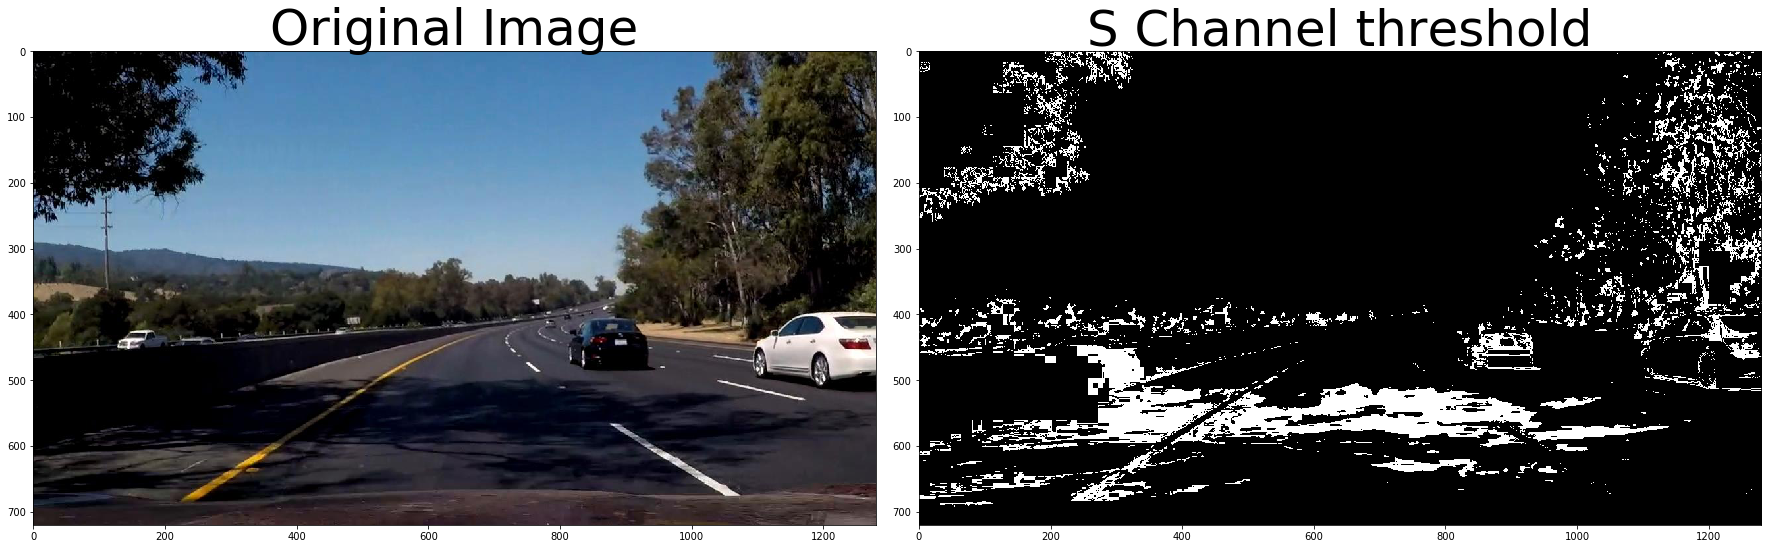

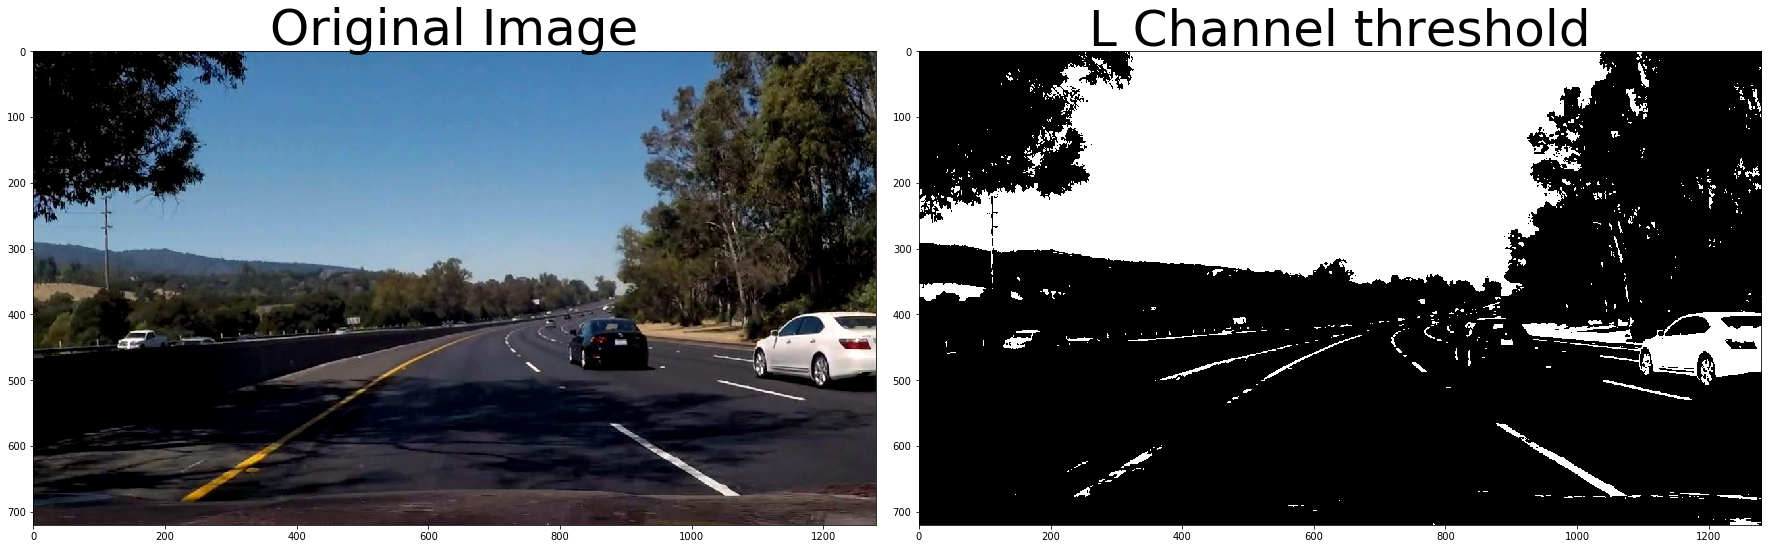

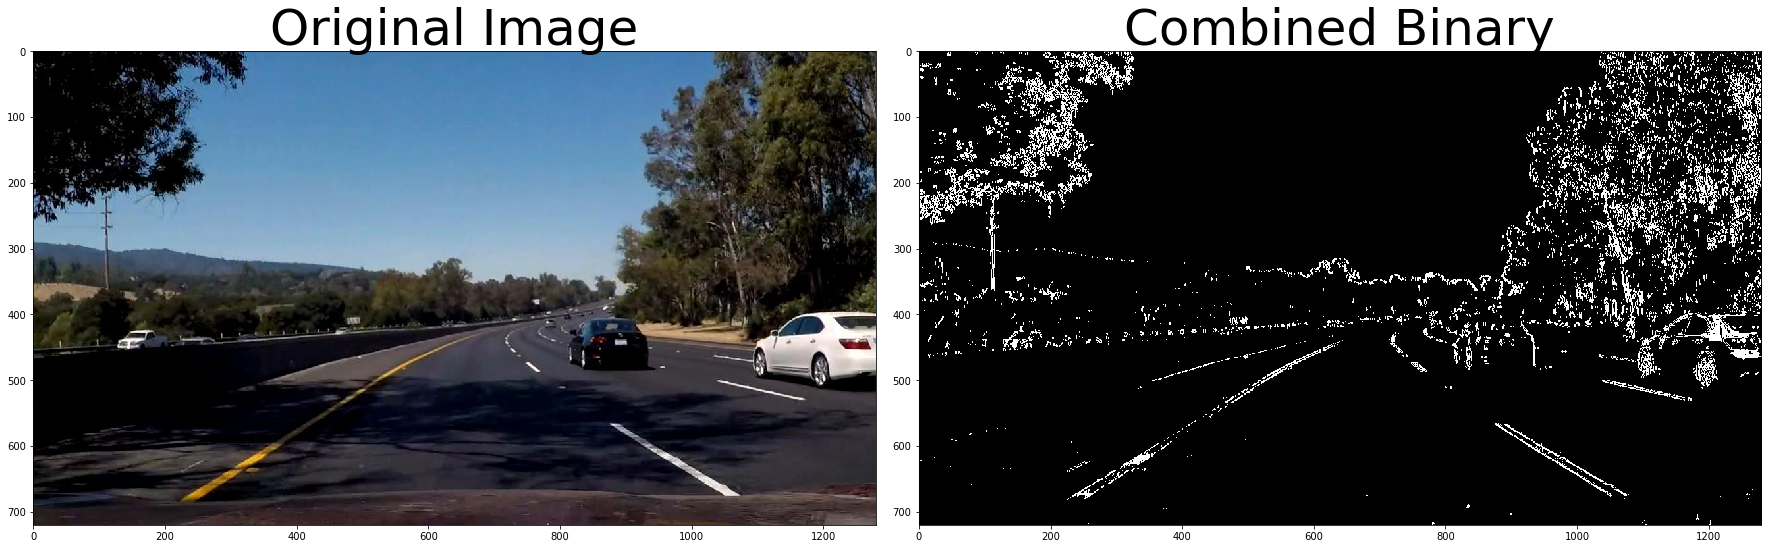

In [16]:
sxbinary, s_binary, l_binary, combined_binary = pipeline(img)
show_2_images(img, 'Original Image', sxbinary, 'X gradient threshold', 'gray')
show_2_images(img, 'Original Image', s_binary, 'S Channel threshold', 'gray')
show_2_images(img, 'Original Image', l_binary, 'L Channel threshold', cmap='gray')
show_2_images(img, 'Original Image', combined_binary, 'Combined Binary', cmap='gray')

In [17]:
# For source points I'm grabbing the outer four detected corners
src = np.float32([[701, 460], #top right
                 [1042, 675], #bottom right
                 [255, 675], #bottom left
                 [573, 460]]) #top left

# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
# again, not exact, but close enough for our purposes
dst = np.float32([[1042, 0], #top right
                 [1042, 712], #bottom right
                 [222, 712], #bottom left
                 [222, 0]]) #top left

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

Minv = cv2.getPerspectiveTransform(dst, src)

In [18]:
def warp(img, src, dst):
    """Given a binary image of road and Perspective transform matrix
    return warped image"""
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

    # Return the resulting image and matrix
    return warped, M, Minv



(<matplotlib.axes._subplots.AxesSubplot at 0x2a758b2fda0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a758b35470>)

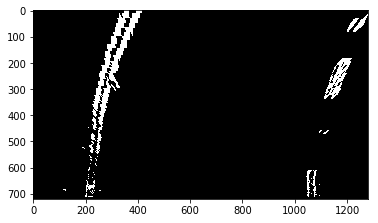

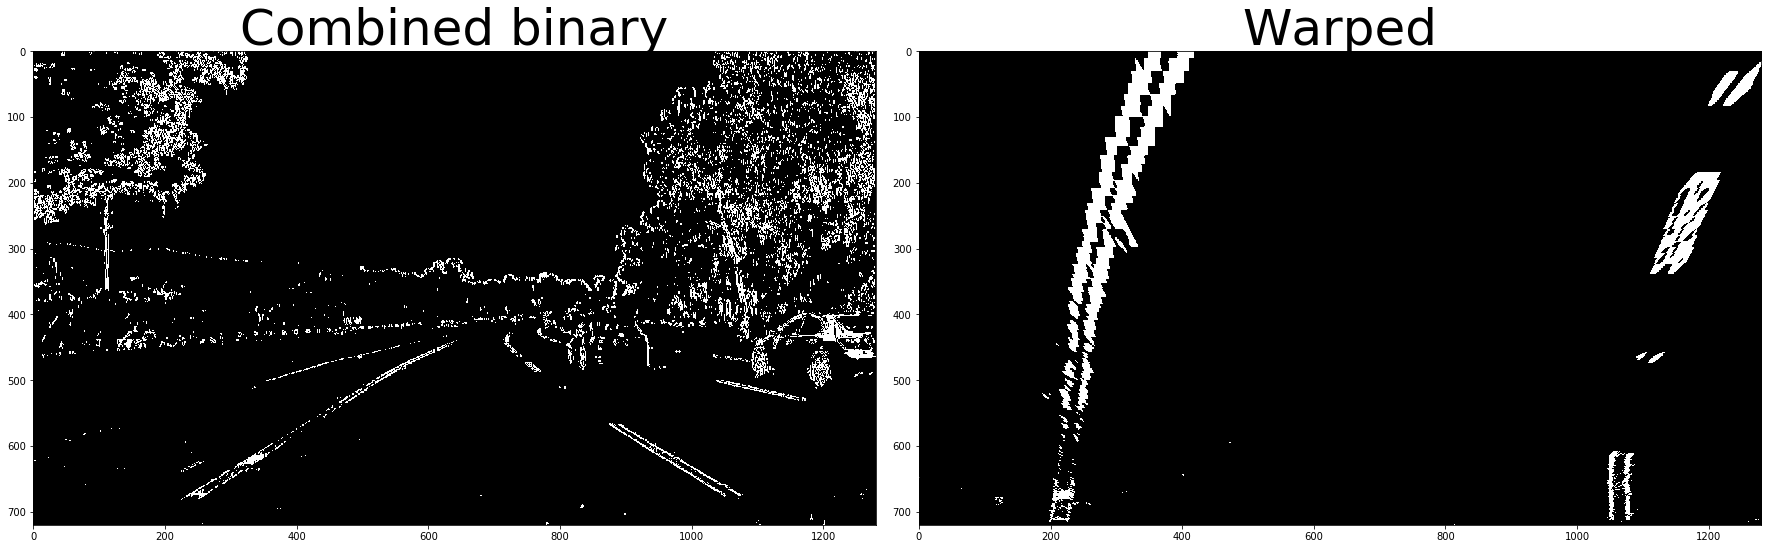

In [19]:
# For source points I'm grabbing the outer four detected corners
src = np.float32([[701, 460], #top right
                     [1042, 675], #bottom right
                     [255, 675], #bottom left
                     [573, 460]]) #top left

# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
# again, not exact, but close enough for our purposes
dst = np.float32([[1042, 0], #top right
                     [1042, 712], #bottom right
                     [222, 712], #bottom left
                     [222, 0]]) #top left

warped, M, Minv = warp(combined_binary, src, dst)
plt.imshow(warped, cmap='gray')
show_2_images(combined_binary, 'Combined binary', warped, 'Warped', cmap='gray')

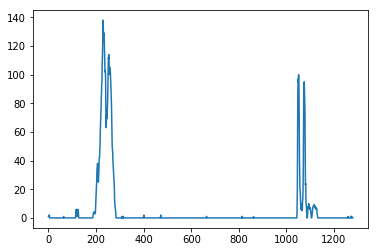

In [20]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

(720, 0)

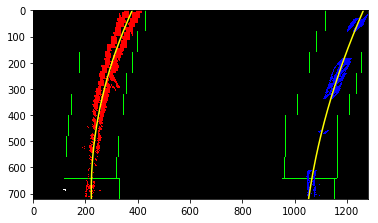

In [21]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
binary_warped = warped
# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

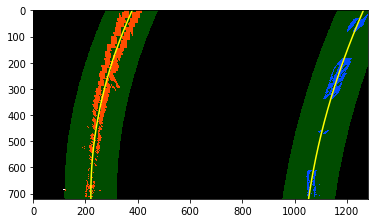

In [22]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [23]:
y_eval = np.max(lefty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

1560.00768221 2528.79785609


In [24]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

512.333412193 m 805.213713284 m


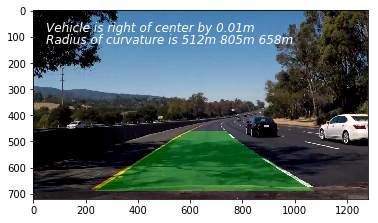

In [25]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image or undistorted image??
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

# Calculate the position of the vehicle
#center = abs(640 - ((rightx_int+leftx_int)/2))

leftx_bottom = left_fitx[result.shape[0] - 1]
rightx_bottom = right_fitx[result.shape[0] - 1]

center = result.shape[1]/2 - (leftx_bottom + rightx_bottom)/2
center_scaled = center * xm_per_pix

plt.imshow(result)
plt.text(50, 125, 'Radius of curvature is {}m {}m {}m'.format(int(left_curverad), int(right_curverad), int((left_curverad + right_curverad)/2)),
             style='italic', color='white', fontsize=12)
if center < 0:
    plt.text(50, 80, 'Vehicle is left of center by {:.2f}m'.format(abs(center_scaled)),
             style='italic', color='white', fontsize=12)
else:
     plt.text(50, 80, 'Vehicle is right of center by {:.2f}m'.format(abs(center_scaled)),
             style='italic', color='white', fontsize=12)

In [26]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # Number of iterations to average n
        self.n = 10
        # Current iteration/frame number
        self.current_frame = 0
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curv = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # deque object to maintain last n fit coefficients
        self.fit_q = deque(maxlen = self.n)
        
    def fill_current_param(self, fit, allx, ally):
        if self.detected == True:
            self.diffs = fit - self.current_fit
        self.current_fit = fit
        self.allx = allx
        self.ally = ally
        
    def update_radius_of_curv(self):
        # Calculate the position of the vehicle
        #center = abs(640 - ((rightx_int+leftx_int)/2))
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(self.ally*ym_per_pix, self.allx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        y_eval = np.max(self.ally)
        curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        self.radius_of_curv = curverad

    def update_fit_q_and_best_fit(self):
        self.fit_q.append(self.current_fit)
        coeff0 = 0
        coeff1 = 0
        coeff2 = 0
        for fit in self.fit_q:
            coeff0 = coeff0 + fit[0]
            coeff1 = coeff1 + fit[1]
            coeff2 = coeff2 + fit[2]
            
        self.best_fit[0] = coeff0/len(self.fit_q)
        self.best_fit[1] = coeff1/len(self.fit_q)
        self.best_fit[2] = coeff2/len(self.fit_q)
        
    



In [27]:
def get_poly(warped):
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    binary_warped = warped
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint 

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty, left_fit, right_fit

In [28]:
def mark_lanes(warped, img, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image or undistorted image??
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    # Calculate the position of the vehicle
    #center = abs(640 - ((rightx_int+leftx_int)/2))
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    leftx_bottom = left_fitx[result.shape[0] - 1]
    rightx_bottom = right_fitx[result.shape[0] - 1]

    center = result.shape[1]/2 - (leftx_bottom + rightx_bottom)/2
    center_scaled = center * xm_per_pix
    """
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(lefty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    cv2.putText(result, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)), (50, 125),
                fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    
    if center < 0:
        cv2.putText(result, 'Vehicle is left of center by {:.2f}m'.format(abs(center_scaled)), (50, 80),
                    fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is right of center by {:.2f}m'.format(abs(center_scaled)), (50, 80),
                    fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    """
    san_check, diff_percent = sanity_check(left_line, right_line)
    cv2.putText(result, 'Radius of curvature is {}m (left - {}m right - {}m) {:.2f}'.format(
                int((left_line.radius_of_curv + right_line.radius_of_curv)/2),
                int(left_line.radius_of_curv),
                int(right_line.radius_of_curv),
                diff_percent),
                (50, 125), fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 1)
    
    if center < 0:
        cv2.putText(result, 'Vehicle is left of center by {:.2f}m'.format(abs(center_scaled)), (50, 80),
                    fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is right of center by {:.2f}m'.format(abs(center_scaled)), (50, 80),
                    fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    
    
    return result

In [29]:
def annotate_lanes(warped, img, Minv):
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    """
    left_fitx = left_line.current_fit[0]*ploty**2 + left_line.current_fit[1]*ploty + left_line.current_fit[2]
    right_fitx = right_line.current_fit[0]*ploty**2 + right_line.current_fit[1]*ploty + right_line.current_fit[2]
    """
    left_fitx = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
    right_fitx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image or undistorted image??
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    # Calculate the position of the vehicle
    #center = abs(640 - ((rightx_int+leftx_int)/2))
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    leftx_bottom = left_fitx[result.shape[0] - 1]
    rightx_bottom = right_fitx[result.shape[0] - 1]

    center = result.shape[1]/2 - (leftx_bottom + rightx_bottom)/2
    center_scaled = center * xm_per_pix
    
    san_check, diff_percent = sanity_check(left_line, right_line)
    cv2.putText(result, 'Radius of curvature is {}m (left - {}m right - {}m) {:.2f}'.format(
                int((left_line.radius_of_curv + right_line.radius_of_curv)/2),
                int(left_line.radius_of_curv),
                int(right_line.radius_of_curv),
                diff_percent),
                (50, 125), fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 1)
    
    if center < 0:
        cv2.putText(result, 'Vehicle is left of center by {:.2f}m'.format(abs(center_scaled)), (50, 80),
                    fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is right of center by {:.2f}m'.format(abs(center_scaled)), (50, 80),
                    fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    """
    cv2.putText(result, 'diffs of coefficients {:.2f} {:.2f} {:.2f}'.format(left_line.diffs[0], left_line.diffs[1], left_line.diffs[2]), (50, 150),
                    fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 1)
    """
    return result

In [30]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def update_poly(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty, left_fit, right_fit

In [31]:
def sanity_check(Left_line, Right_line):
    #Check the difference between radius of curvature of left and right line is less than 50%
    max_rad = max(Left_line.radius_of_curv, Right_line.radius_of_curv)
    diff = abs(Left_line.radius_of_curv - Right_line.radius_of_curv)
    diff_percent = diff/max_rad
    if diff_percent > 0.5:
        return False, diff_percent
    else:
        return True, diff_percent
    

In [ ]:
def process_vid(image):
    undistorted = cal_undistort(image, mtx, dist)
    sxbinary, s_binary, l_binary, combined_binary = pipeline(undistorted)
    
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[701, 460], #top right
                     [1042, 675], #bottom right
                     [255, 675], #bottom left
                     [573, 460]]) #top left

    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[1042, 0], #top right
                     [1042, 712], #bottom right
                     [222, 712], #bottom left
                     [222, 0]]) #top left
    
    warped, M, Minv = warp(combined_binary, src, dst)
    
    if left_line.detected == False:
        ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty, left_fit, right_fit = get_poly(warped)
        left_line.detected = True 
        left_line.best_fit = left_fit
        right_line.best_fit = right_fit
    else:
        ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty, left_fit, right_fit = update_poly(warped, left_line.current_fit, right_line.current_fit)
    
    left_line.fill_current_param(left_fit, leftx, lefty)
    right_line.fill_current_param(right_fit, rightx, righty)
    
    left_line.update_radius_of_curv()
    right_line.update_radius_of_curv()
    
    san_check, diff_percent = sanity_check(left_line, right_line)
    if san_check == False:
        ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty, left_fit, right_fit = get_poly(warped)
        left_line.fill_current_param(left_fit, leftx, lefty)
        right_line.fill_current_param(right_fit, rightx, righty)
    
        left_line.update_radius_of_curv()
        right_line.update_radius_of_curv()
        
    #result = mark_lanes(warped, undistorted, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty, Minv)
    san_check, diff_percent = sanity_check(left_line, right_line)
    if san_check == True:
        left_line.update_fit_q_and_best_fit()
        right_line.update_fit_q_and_best_fit()
    
    result = annotate_lanes(warped, undistorted, Minv)
    return result

In [ ]:
from moviepy.editor import VideoFileClip


left_line = Line()
right_line = Line()

video_output = 'out_video.mp4'
clip1 = VideoFileClip("../project_video.mp4")#.subclip(40,42)
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video out_video.mp4
[MoviePy] Writing video out_video.mp4


 55%|███████████████████████████████████████████████████████████████████████▋                                                           | 690/1261 [02:16<01:39,  5.75it/s]

In [ ]:
clip1.save_frame('../test_images/test10.jpg', 21.90)